# Introduction

In recent years, we are evident of several changes in the music industry. Some of these changes can be associated with the consumers, as the magnitude and platforms of consumption grew. At the same time, innovations on behalf of the artists led to new genres of music to arise. One outcome of said changes is the rising presence of explicit lyrical content within the songwriting process, and the large exposure to it , especially of the youth.

Thus, in the scope of this project, we wanted to test whether having explicit lyrics has any considerable effect on the popularity of the song.

Hence, we can formulate the following question: "Does the presence of explicit content in a song's lyrics increase its popularity?".

## Explicit Content  

Regarding the definition of "explicit lyrical content", there is no general consensus. Obviously, culture has a major effect on the matter, with lots of considerations about the intended audience and the listening context.

As of today, the decision regarding the presence of explicit content in songs lyrics is done mostly by humans. This can be done by either the rights-holders of the song who inform the different platforms (Spotify, YouTube etc.), or by user based flagging when consuming the content.

## Songs Popularity

Generally speaking, the popularity of a song can be measured by the amount of times it has been listened to by the public. One key observation to make is the rise of different platforms one can use to listen to music. 

In the beggining-middle of the 20th century, the main platforms were the radio and sales of physical copies of songs, where as today we have online streaming platforms and apps. Since 1958, the "Billboard Hot 100" weekly chart has been considered by many as the concensus for most popular songs. 

These days, these chart rankings approximate weighting is 35-45% for sales, 30-40% for airplay, and 20-30% for streaming. An annual "year end" chart is also released, ranking that year's songs by calculating a cumulative total of sales, airplay, and streaming


We believe our research will show that explicit content has a positive effect on the popularity of a given song. I.e., a song which contains explicit lyrical content will have a higher chance of being popular. 
<font color='red'>Add why we believe this is the case</font>



# Data

In this project, we will use the following [data](https://www.kaggle.com/datasets/ektanegi/spotifydata-19212020).
This data-set contains approximately 169,000 songs from Spotify, spanning between 1921 and 2020. For each year, the top 100 songs - according to spotify - were recorded.

For each song, we have several types of features such as song charactaristic (e.g., tempo and danceability), and general information regarding the song (e.g., artist name, published year and song name).

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [2]:
df = df = pd.read_csv('data/spotify1921-2020.csv', converters={'artists': literal_eval})

## Defining the Treatment and Effect

As per our causal question formulation, the treatment and effect are the 'explicit ' and 'popularity' columns of the data respectivally.

The popularity column is Spotify's popularity rating index, which ranges from 0-100.
The explicit column is Spotify's explicit content flag, ehich is binary (0 = No explicit content, 1 = Explicit content)

As for this point forward, these columns will be reffered as treatment and effect. 

In [3]:
# we mark our treatment as the "explicit" column and our effect as the popularity column
# (treatment is binary and popularity ranges from 0 to 100)
df = df.rename(columns={'explicit': 'treatment', 'popularity': 'effect'})


## Data Preprocessing

In this section, we removed columns which were irrelevant for our research question.
Firstly, we removed the 'id' as it is only an identifier for a record, and has no influence.
Moreover, since the song name doesnt effect neither the popularity nor the presence of explicit content in the lyrics, it was removed as well.  We also removed the full release date feature, as we were only interested in the year of publishing, which was an individual feature present in the data. The month and day were not as important.

In [4]:
# we remove the release_date column as its format is not consistent across all records
# some records have the complete date, some have the year only - we take the year only
df = df.drop(columns=['release_date'])
# we remove id, song name and artist name as they are not useful for our analysis
df = df.drop(columns=['id', 'name'])


## Data Transformation

As to the artists of the song, we believe that it has an effect on both the potential presence of explicit lyrics in the song, and on the potential populrity of a song.
Usually, an artist has a signature style of music, which can be characarized with the presence of explicit lyrics - such as rap and hip-hop. In addition, an artist can enjoy the attention of the public, and can gain interest about a future song, even before publishing it. Thus, we need to find a way to endoce the artist into the data , as it is a confounding element in our opinion.

Yet, there are several thousands different artist, so a plain one-hot encoding was not applicable.
Our solution to this problem is as follows: firstly, we used only the main artist of every song (in the case of collaborations), and for every song, we estimated the popularity and tendency to explicit content by averaging those parameters across past songs of the main artist.

This transformation of the treatment (explicit content) can be thought of as calculating the probability of an artist to write a song with explicit content, when writing the current song. Similarily, the transformation of the effect (popularity) can be seen as the estimated potential interest of the public for the artist's new song.

In [5]:
# to extract information from the artists column, without having to add a one-hot encoding for each artist (4000+)
# we will instead, try to extract a "popularity" and "explicitness" for each song based on the artists that are associated with it
# we will do this by taking the average popularity and explicit of all the previous songs from the artists that are associated with it
# we take only the first artist as the main artist
df['artists'] = df['artists'].apply(lambda x: x[0])
df = df.sort_values(by=['artists', 'year'])
# 2234 is the max amount of songs by an artist
df['previous_artist_explicitness'] = df.groupby('artists')['treatment'].transform(lambda x: x.shift(1).rolling(2234, min_periods=1).mean()).fillna(0)
df['previous_artist_popularity'] = df.groupby('artists')['effect'].transform(lambda x: x.shift(1).rolling(2234, min_periods=1).mean()).fillna(0)
df = df.drop(columns=['artists'])


In [6]:
# reorder all the columns
df = pd.concat([df.loc[:, ~df.columns.isin(['treatment', 'effect'])], df.loc[:, ['treatment', 'effect']]], axis=1)


After all the transformation and pre-processing, the main features we will use in the project are:
- Acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- energy (Ranges from 0 to 1)
- instrumentalness (Ranges from 0 to 1)
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
- liveness (Ranges from 0 to 1)
- loudness (Adjusted to -14 dB LUFS, according to the ITU 1770 standard)
- mode (0 = Minor, 1 = Major)
- speechiness (Ranges from 0 to 1)
- tempo (Float typically ranging from 50 to 150)
- valence (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)
- treatment (0 = No explicit content, 1 = Explicit content)
- effect (Ranges from 0 to 100)
- previous_artist_explicitness (As explaine dprevously)
- previous_artist_popularity (As explaine dprevously)

# Data Analysis and Statistics

In [7]:
print(df.describe(percentiles=[]).iloc[1:,0:7].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  acousticness &  danceability &   duration\_ms &    energy &  instrumentalness &        key &  liveness \\
\midrule
mean &      0.493214 &      0.538150 &  2.314062e+05 &  0.488593 &          0.161937 &   5.200519 &  0.206690 \\
std  &      0.376627 &      0.175346 &  1.213219e+05 &  0.267390 &          0.309329 &   3.515257 &  0.176796 \\
min  &      0.000000 &      0.000000 &  5.108000e+03 &  0.000000 &          0.000000 &   0.000000 &  0.000000 \\
50\%  &      0.492000 &      0.548000 &  2.086000e+05 &  0.481000 &          0.000204 &   5.000000 &  0.135000 \\
max  &      0.996000 &      0.988000 &  5.403500e+06 &  1.000000 &          1.000000 &  11.000000 &  1.000000 \\
\bottomrule
\end{tabular}



In [8]:
print(df.describe(percentiles=[]).iloc[1:,7:].to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &   loudness &      mode &  speechiness &       tempo &   valence &         year &  previous\_artist\_explicitness &  previous\_artist\_popularity &  treatment &      effect \\
\midrule
mean & -11.370289 &  0.708556 &     0.094058 &  116.948017 &  0.532095 &  1977.223231 &                      0.074552 &                   25.331268 &   0.084863 &   31.556610 \\
std  &   5.666765 &  0.454429 &     0.149937 &   30.726937 &  0.262408 &    25.593168 &                      0.241215 &                   20.481236 &   0.278679 &   21.582614 \\
min  & -60.000000 &  0.000000 &     0.000000 &    0.000000 &  0.000000 &  1921.000000 &                      0.000000 &                    0.000000 &   0.000000 &    0.000000 \\
50\%  & -10.474000 &  1.000000 &     0.045000 &  114.778000 &  0.544000 &  1978.000000 &                      0.000000 &                   27.875000 &   0.000000 &   33.000000 \\
max  &   3.855000 &  1.000000 &     0.969000 &  244.091000 &

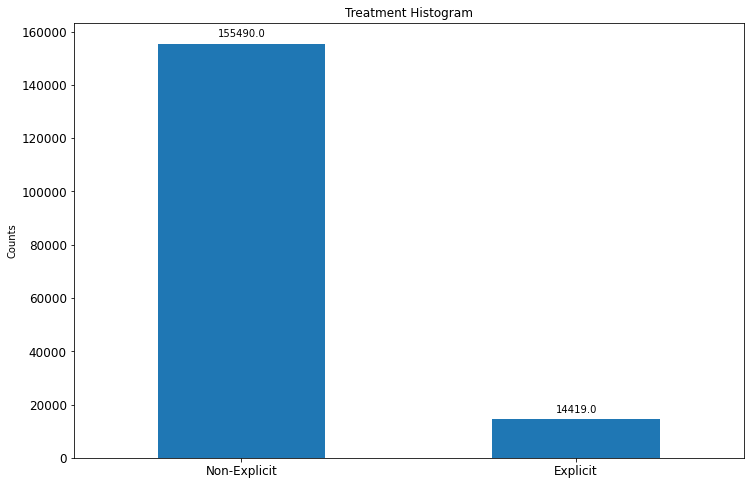

In [9]:
import matplotlib.pyplot as plt
# plot histogram of treatment column
_, ax = plt.subplots(figsize=(12, 8))
df['treatment'].value_counts().plot(kind='bar', title='Treatment Histogram', figsize=(12, 8), fontsize=12, ax=ax)
plt.xticks(rotation=0)
ax.set_xticklabels(['Non-Explicit', 'Explicit'])
# add values to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.ylabel('Counts')
plt.show()

First of all, we can see that the treatment distribution in the data-set is highly imbalanced. Roughly 8.5% of the songs are labeled as containing explicit content, while the rest are labeled the opposite.
Whilst this imbalance is not ideal, we still have sufficient amount of records for both categories, thus not harming our potential conclusions. Nevertheless, we will adress this imbalance where neccesary.

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_14352/1736813439.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


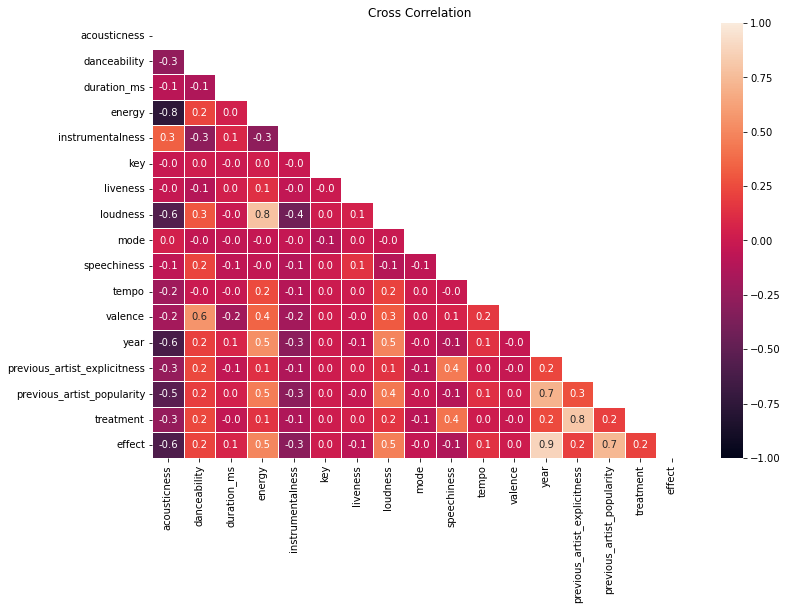

In [11]:
# option 2 for correlation
# cross correlation between our features, the treatment and the effect
# plot as matplotlib heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
_, ax = plt.subplots(figsize=(12, 8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True,linewidths=.5, fmt='.1f')
ax.title.set_text('Cross Correlation')
plt.show()

From the chart above we can see that the treatment feature, which represents the presence of explicit content in the song, is somewhat correlated to only two features - speechiness of the song and the artist's previous explicitness. This result shouldnt come as a surprise, as the more words the song has the higher the probability it has to include explicit content. Likewise, the more explicit content an artist has in previous songs, the more likely he is to include it in a future song. 

Furthermore, we can see that the effect is highly positively-correlated with the publishing year of the song, which is logical. The increase of music listening platforms and their accecability, allows for further exposure for music in the last decades. 

<font color='red'>Assume that data from early years is not so well documented</font> 

We can also see that features like energy and loudness are somewhat positively correlated with the effect, and that accousticness is has the opposite trend. 

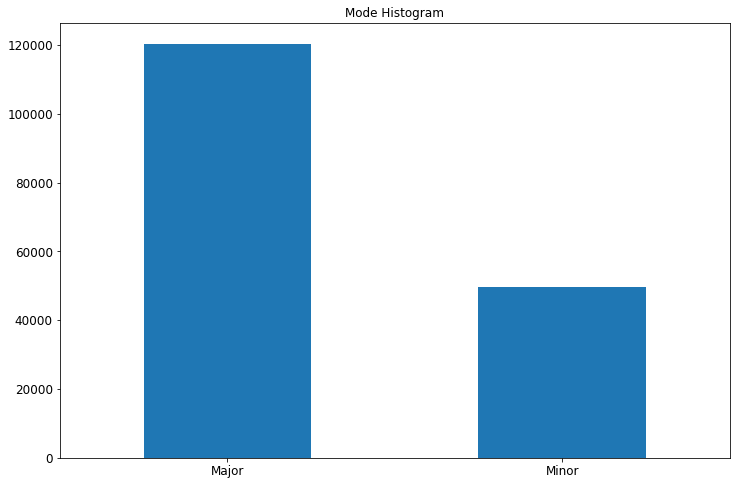

In [12]:
# plot histogram of mode column
_, ax = plt.subplots(figsize=(14, 10))
df['mode'].value_counts().plot(kind='bar', title='Mode Histogram', figsize=(12, 8), fontsize=12, ax=ax)
plt.xticks(rotation=0)
ax.set_xticklabels(['Major', 'Minor'])
plt.ylabel('Counts')
plt.show()

As we can see, the mode is mostly major <font color='red'>So What??????</font> 

The amount of records per year is capped at 2,000 (data includes top 2000 songs of each year)
As we can see, early years have a lower number of records, and also the last 10 years has little less records (the difference is not significant)

The large difference between the 2000 recored value to the values of the yers prior to 1950 could be explained by the growth of music  streaming & listening platforms. The rise of record stores, personal consumption formats and most recently online streaming platforms, allowed for beter estimation of the popularity of songs.

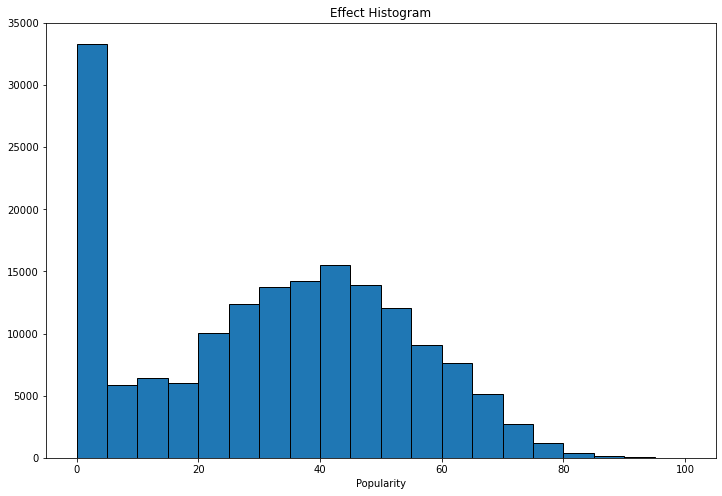

In [14]:
# plot histogram of effect column
_, ax = plt.subplots(figsize=(12, 8))
bins = list(range(0, 101, 5))
plt.hist(df.effect.values, bins=bins, edgecolor="k")
ax.set_xlabel('Popularity')
plt.xticks(rotation=0)
ax.title.set_text('Popularity Histogram')
plt.ylabel('Counts')
plt.show()

As we can see, there is a high value for 0-5, however, the distribution is still normal with median around 45-50
This sets the question, why are there so many records with popularity 0-5?
we will check in the next graph, whether it is because early years have lower popularity (due to unrecorded popularity maybe)

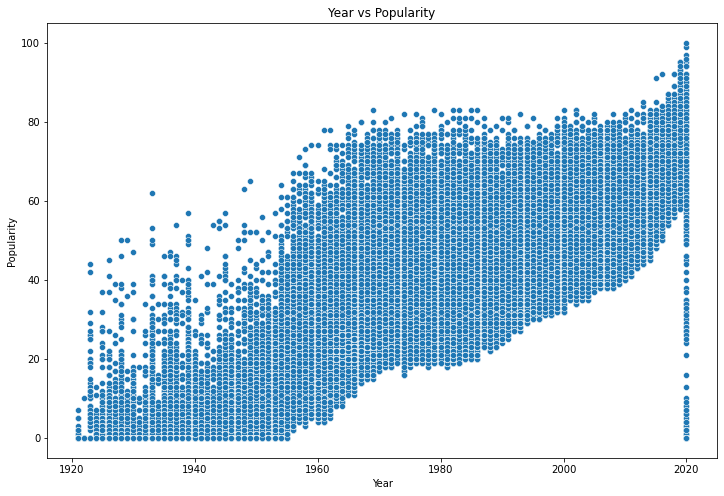

In [15]:
#  plot of year vs effect
_, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='year', y='effect', data=df, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Popularity')
ax.title.set_text('Year vs Popularity')
plt.show()

From the graph above, we can indeed see that the distribution of the popularity measure for years prior to 1950~1960 is is lower compared to later years. I.e., overall, songs from these years are less popular when cpmpared to songs later on. This result was indicated prevously, as we saw a positive correlation between the song's publishing year and the popularity. 

When considering the way Spotify generates it's popularity rating, we could obtain an explanation to phenomena described above. Spotify creates it's popularity rating mostly based on the total number of plays the track has had and how recent those plays are. Thus, the difference of the rating distribution could be explained by the fact that people nowadays simply don listen to song prior to 1950, as much as they listen to songs published after. 

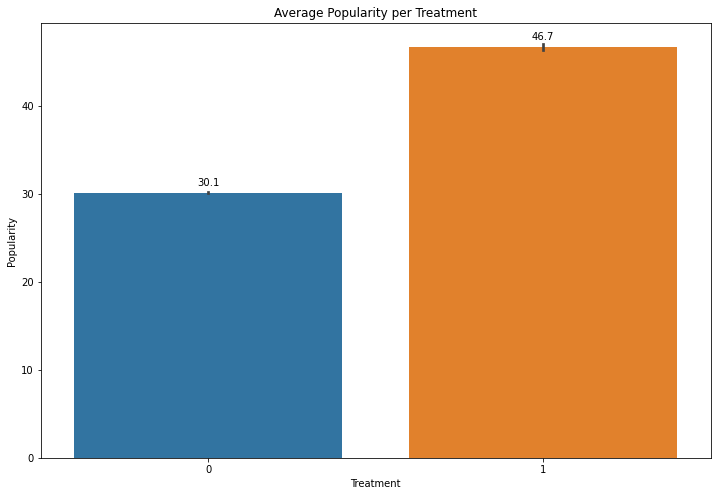

In [16]:
# plot average effect per treatment
_, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='treatment', y='effect', data=df, ax=ax)
ax.set_xlabel('Treatment')
ax.set_ylabel('Popularity')
ax.title.set_text('Average Popularity per Treatment')
# add values to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

Lastly, we can see that the average popularity is higher for explicit than for non-explicit, hence, we might indeed witness that the treatment affects the effect.

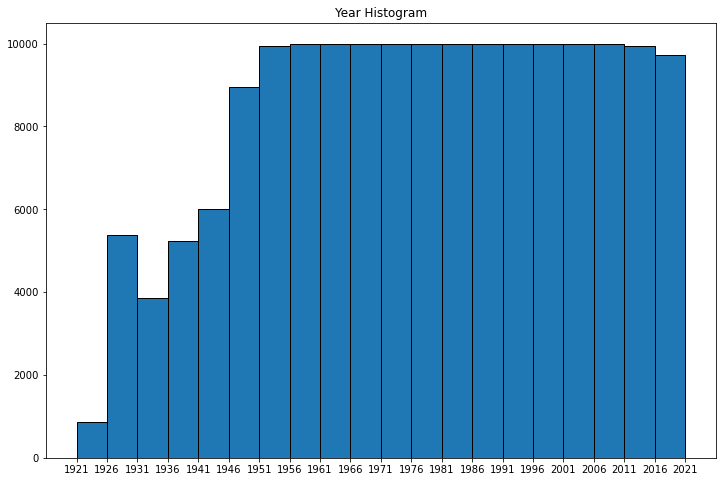

In [17]:
# plot histogram of year column
_, ax = plt.subplots(figsize=(12, 8))
bins = list(range(1921, 2022, 5))
plt.hist(df.year.values, bins=bins, edgecolor="k")
plt.xticks(bins)
ax.title.set_text('Year Histogram')
plt.
plt.show()

The amount of records per year is capped at 2,000 (data includes top 2000 songs of each year)
As we can see, early years have a lower number of records, and also the last 10 years has little less records (the difference is not significant)

The large difference between the 2000 recored value to the values of the yers prior to 1950 could be explained by the growth of music  streaming & listening platforms. The rise of record stores, personal consumption formats and most recently online streaming platforms, allowed for beter estimation of the popularity of songs.

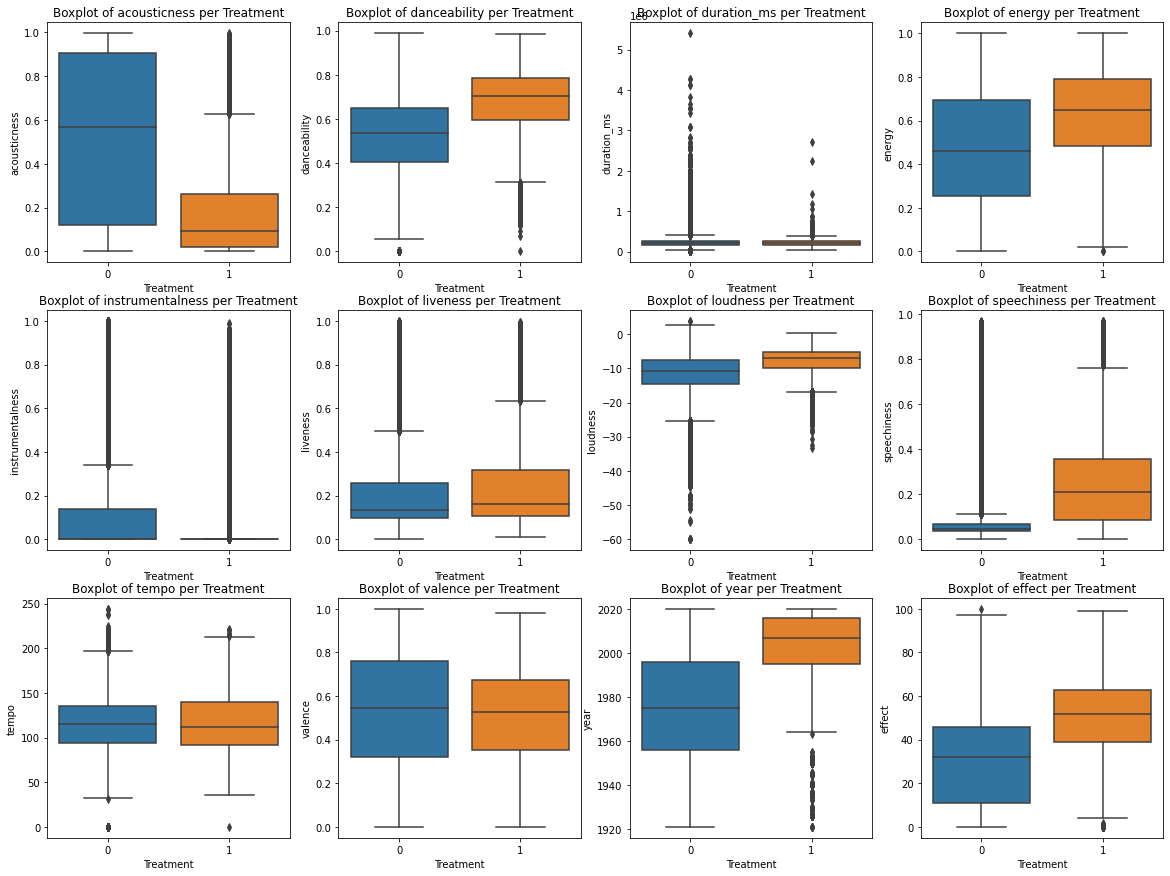

In [19]:
# plot a boxplot for each feature in both groups of treatment
_, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, col in enumerate(df.columns[~df.columns.isin(['treatment', 'previous_artist_popularity', 'previous_artist_explicitness', 'mode', 'propensity_score', 'key'])]):
    ax = axes[i // 4, i % 4]
    sns.boxplot(x='treatment', y=col, data=df, ax=ax)
    ax.set_xlabel('Treatment')
    ax.set_ylabel(col)

    ax.title.set_text(f'Boxplot of {col} per Treatment')
plt.show()

From the graph above, we can indeed see that the distribution of the popularity measure for years prior to 1950~1960 is is lower compared to later years. I.e., overall, songs from these years are less popular when cpmpared to songs later on. This result was indicated prevously, as we saw a positive correlation between the song's publishing year and the popularity. 

When considering the way Spotify generates it's popularity rating, we could obtain an explanation to phenomena described above. Spotify creates it's popularity rating mostly based on the total number of plays the track has had and how recent those plays are. Thus, the difference of the rating distribution could be explained by the fact that people nowadays simply don listen to song prior to 1950, as much as they listen to songs published after. 

Lastly, we can see that the average popularity is higher for explicit than for non-explicit, hence, we might indeed witness that the treatment affects the effect.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def calculate_propensity_score(df):
    scaled = StandardScaler().fit_transform(df.drop(['effect', 'treatment'], axis=1))
    LR = LogisticRegression(random_state=0)
    LR.fit(scaled, df['treatment'])
    prop = LR.predict_proba(scaled)[:, 1]

    return prop

# calculate propensity score
df['propensity_score'] = calculate_propensity_score(df)

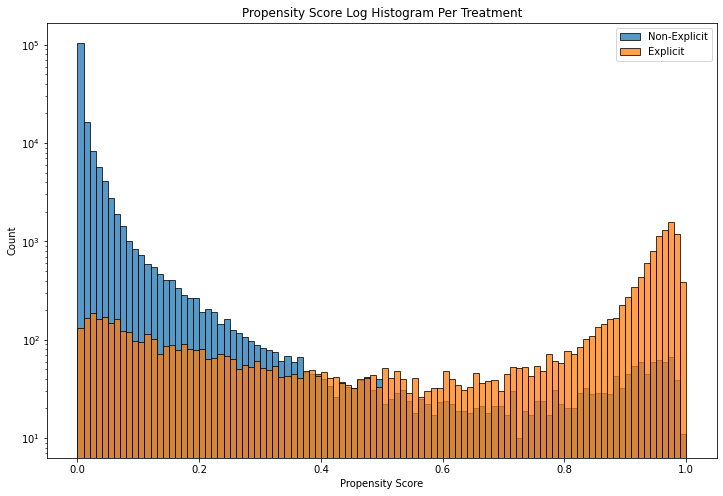

In [21]:
# plot propensity score histogram stacked by treatment, log scale
import numpy as np
_, ax = plt.subplots(figsize=(12, 8))
bins = np.arange(0, 1.01, 0.01)
plt.hist(df.propensity_score[df.treatment == 0].values, bins=bins, edgecolor="k", log=True, alpha=0.75, label='Non-Explicit')
plt.hist(df.propensity_score[df.treatment == 1].values, bins=bins, edgecolor="k", log=True, alpha=0.75, label='Explicit')
ax.set_xlabel('Propensity Score')
ax.set_ylabel('Count')
ax.title.set_text('Propensity Score Log Histogram Per Treatment')
ax.legend()
plt.show()

In [22]:
df.drop('propensity_score',axis=1)
df.to_csv('data/final_data.csv', index=False)

# Causal Inference Assumptions

In this section we will show that all the required assumptions regarding causal inference holds in our dataset.

## SUTVA

The SUTVA assumption requires the standing of two statements. First, we require that the potential outcomes for any unit do not vary with the treatments assigned to other units. Second, we require that for each unit, there are no different forms or
versions of each treatment level, which lead to different potential outcomes.

We can see that the first statement holds, as the popularity of one song, is not effected by the presence of explicit content in another song. <font color='red'> As we have previously stated, the popularity measure encapsulates the number of times a given song was played in a recent time peroid. Since there is no limitation for the user  </font>.

As for the second statement, we can see it clearly holds since our treatment is binary. 

## Consistency

The consistency assumption requires that tor a unit that receives treatment $T$, we observe the
corresponding potential outcome $Y_t$. This assumption clearly holds in our case study, since both the popularity and the explicit content presence are observed for each song.

## Ignorability

The ignorability assumption requires that there are no hidden confounders. I.e., The potential outcomes are independent of treatment assignment, conditioned on observed covariates $x$. Obviously, this assumption is relatively hard to ensure it's holding. However, as we tried to think about possible unmeasured variables that may affect both treatment and effect, we often managed to neglect its impact through the presence of the variables already in the dataset. For example, one feature not present in the data is the genre. As one could assume, the genre affects both the popularty of the song, and the probability of it containing explicit content. However, the different genres can be represented by other features such as loudness, danceability, accousticness etc. Meaning, when observing these features, the impact of the lack of the genre is neglected.

## Common Support

The common support assumption requires that each of the treatment variations has a positive probability of being assigned to each record, as can be seen in the Propensity Score Log Histogram Per Treatment plot.

# Methods

In this section we will describe the four methods we will use in order to estimate $ATE$.

## S-Learner

In this method we want to learn a function $\hat{y} = f(x_i,t)$ that predicts the outcome (popularity) for all records given their features and treatment. We then use this function to predict each of the potential outcomes $Y_1$ and $Y_0$ by manually setting the treatment to be 1 and 0 respectivally, whilst the other features remain the same. We estimate the ATE by averaging the difference between the results: $$\widehat{ATE} = \frac{1}{n} \sum \limits _{i=1} ^{n} f(x_i,1) - f(x_i,0) $$

We will use linear regression in order to learn the said function $f(x_i,t)$.
 


## T-Learner

In this method we want to learn two different function  $\hat{y} = f_t(x_i)$ that predicts the outcome (popularity) for all records given their features, when records are grouped by their treatment. Meaning, we learn a function $f_1(x_i)$ using songs with explicit content, and function $f_0(x_i)$ using the other songs. We then use these functions to predict each of the potential outcomes $Y_1$ and $Y_0$ by using $f_1(x_i)$ and $f_0(x_i)$ respectivally.  We estimate the ATE by averaging the difference between the results: $$\widehat{ATE} = \frac{1}{n} \sum \limits _{i=1} ^{n} f_1(x_i) - f_0(x_i) $$

Similarly to the S-Learner, we will use linear regression when learning the two functions.

## IPW

In this method we used Logistic Regresison model to calculate the propensity score of each record in the dataset $\widehat{e_i} = \hat{p}(T^i=1|X)$. We then used these scores to estimate the ATE by weighting each record's effect by the propensity scores.

$$\widehat{ATE} = \frac{1}{n} (\sum \limits _{i s.t  T_i=1} \frac{y_i}{\widehat{e_i}} - \sum \limits _{i s.t  T_i=0} \frac{y_i}{1-\widehat{e_i}} )$$

## Matching

In this method we create a counterfactual for each of the records in the data. We achieve this by using 1-NN algorithm, learned by one group of the data, and predicted on the other. I.e., we first train a model on the set of records with explicit content, and then predict it on the set of records without it. Then, we repeat the process the other way around.

Formally, we can denote the counterfactual of the i'th sample as $$ J(i) = argmin_{j  s.t. T_i \neq T_j} d(x_i,x_j)$$

Afterwards, we will calculate the ITE for each record: $$ \widehat{ITE} = y_i-y_J(i) if  T=1, and y_J(i)-Y_i otherwise $$


Finally, the $ATE$ is estimated by averaging the $ITE$ across the records: $$\widehat{ATE} = \frac{1}{n} \sum \limits _{i=1} ^{n} \widehat{ITE}(i)$$

# Results

As previously stated, our dataset is highly imbalanced in favour of the non-explicit records. Thus, we have decided to tackle this issue by generating multiple bootstrap datasets, while ensuring label ba

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import gc
class ATE_calculator:
    def __init__(self, df):
        self.df = df
        # separate the data into treated and not treated
        self.df_T0 = self.df[self.df['treatment'] == 0]
        self.df_T1 = self.df[self.df['treatment'] == 1]
        self.propensity = self.calculate_propensity_score()
        # save the results to a dictionary
        self.results = {}

    def calculate_propensity_score(self):
        scaled = StandardScaler().fit_transform(self.df.drop(['effect', 'treatment'], axis=1))
        LR = LogisticRegression(random_state=0)
        LR.fit(scaled, self.df['treatment'])
        prop = LR.predict_proba(scaled)[:, 1]

        return prop

    def calculate_IPW_ATE(self):
        
        def ATE_IPW_formula(y, t, e):
            left = sum(t * y/e) 
            right = sum((1 - t) * y / (1 - e))
            return (left - right)/len(y)

        # calculate the IPW ATT by the function we built
        ATE_IPW = ATE_IPW_formula(self.df['effect'], self.df['treatment'], self.propensity)
        # add results to the dictionary
        self.results['ATE_IPW'] = ATE_IPW

        return ATE_IPW

    def calculate_S_Learner_ATE(self):
        # learn a linear function with all data
        S_learner = sm.OLS(self.df['effect'], self.df.drop('effect', axis=1)).fit()

        # pred only on treated data 
        dummy_treated_0 = self.df.drop(['effect'],axis=1)
        dummy_treated_0['treatment'] = 0
        dummy_treated_1 = self.df.drop(['effect'],axis=1)
        dummy_treated_1['treatment'] = 1
        y_pred_0 = S_learner.predict(dummy_treated_0)
        y_pred_1 = S_learner.predict(dummy_treated_1)
        
        ATE_S_learner = np.mean(y_pred_1 - y_pred_0) 
        # add results to the dictionary
        self.results['ATE_S_learner'] = ATE_S_learner

        return ATE_S_learner

    def calculate_T_Learner_ATE(self):
        # learn a linear function for the not treated data only
        T0_learner = sm.OLS(self.df_T0['effect'], self.df_T0.drop(['treatment', 'effect'], axis=1)).fit()

        # learn a linear function for the treated data only
        T1_learner = sm.OLS(self.df_T1['effect'], self.df_T1.drop(['treatment', 'effect'], axis=1)).fit()

        # pred only on treated data using both models
        y_pred_0 = T0_learner.predict(self.df.drop(['treatment', 'effect'], axis=1))
        y_pred_1 = T1_learner.predict(self.df.drop(['treatment', 'effect'], axis=1))
        ATE_T_learner = np.mean(y_pred_1 - y_pred_0) 
        
        # add results to the dictionary
        self.results['ATE_T_learner'] = ATE_T_learner

        return ATE_T_learner

    def calculate_matching_ATE(self):
        knn_0 = KNeighborsRegressor(n_neighbors=1)
        knn_0.fit(self.df_T0.drop('effect', axis=1), self.df_T0['effect'])
        ATE_matching_1 = (self.df_T1['effect'] - pd.Series(knn_0.predict(self.df_T1.drop('effect', axis=1)), index=self.df_T1.index)).sum()
        
        del(knn_0)
        gc.collect()
        
        knn_1 = KNeighborsRegressor(n_neighbors=1)
        knn_1.fit(self.df_T1.drop('effect', axis=1), self.df_T1['effect'])
        ATE_matching_0 = (pd.Series(knn_1.predict(self.df_T0.drop('effect', axis=1)), index=self.df_T0.index) - self.df_T0['effect']).sum()

        del(knn_1)
        gc.collect()
        
        
        # add results to the dictionary
        ATE_matching = (ATE_matching_1 + ATE_matching_0)/len(self.df)
        
        self.results['ATE_matching'] = ATE_matching

        return ATE_matching

    def print_results(self):
        print("ATE_IPW:", self.results['ATE_IPW'])
        print("ATE_S_learner:", self.results['ATE_S_learner'])
        print("ATE_T_learner:", self.results['ATE_T_learner'])
        print("ATE_matching:", self.results['ATE_matching'])

In [24]:
# Without bootstrap
ate2 = ATE_calculator(df)
print(ate2.calculate_IPW_ATE())
print(ate2.calculate_S_Learner_ATE())
print(ate2.calculate_T_Learner_ATE())
# print(ate2.calculate_matching_ATE())

0.4092248213238289
2.82852543366584
16.966207815469133


In [25]:
from scipy import stats 
def CI(arr,alpha=0.05):
    Z = z=stats.norm.ppf(q=1-alpha/2)
    return [np.mean(arr)-Z*np.std(arr),np.mean(arr)+Z*np.std(arr)]

In [26]:
# With bootstrap and rebalance
IPW_arr,SL_arr,TL_arr,Match_arr = [],[],[],[]
n = len(df[df['treatment']==1])
for b in range(250):
    if b%10 ==0:
        print(b)
    bootstrap_Exp = df[df['treatment']==1].sample(n,replace=True)
    bootstrap_NonExp = df[df['treatment']==0].sample(n,replace=True)
    cur_df = pd.concat([bootstrap_Exp,bootstrap_NonExp])
    ate1 = ATE_calculator(cur_df)
    IPW_arr.append(ate1.calculate_IPW_ATE())
    SL_arr.append(ate1.calculate_S_Learner_ATE())
    TL_arr.append(ate1.calculate_T_Learner_ATE())
#     Match_arr.append(ate1.calculate_matching_ATE())

    


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [27]:
print(np.mean(IPW_arr),np.mean(SL_arr),np.mean(TL_arr))

-25.068951833776236 9.886257683885486 6.458210772438084


In [28]:
IPW_CI = CI(IPW_arr)
SL_CI = CI(SL_arr)
TL_CI = CI(TL_arr)
# Match_CI = CI(Match_arr)
print(IPW_CI,SL_CI,TL_CI)

[-43.82387143816949, -6.314032229382978] [9.324492893280237, 10.448022474490735] [5.089468384479791, 7.826953160396378]


In [29]:
# With bootstrap without rebalance
IPW_arr,SL_arr,TL_arr,Match_arr = [],[],[],[]
n = len(df)
for b in range(250):
    if b%10 ==0:
        print(b)
    cur_df = df.sample(n,replace=True)
    ate3 = ATE_calculator(cur_df)
    IPW_arr.append(ate3.calculate_IPW_ATE())
    SL_arr.append(ate3.calculate_S_Learner_ATE())
    TL_arr.append(ate3.calculate_T_Learner_ATE())
#     Match_arr.append(ate3.calculate_matching_ATE())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [30]:
print(np.mean(IPW_arr),np.mean(SL_arr),np.mean(TL_arr))

0.4187641271624108 2.8281899226389755 16.969457721771082


In [31]:
IPW_CI = CI(IPW_arr)
SL_CI = CI(SL_arr)
TL_CI = CI(TL_arr)
# Match_CI = CI(Match_arr)
print(IPW_CI,SL_CI,TL_CI)

[-5.205853475883427, 6.043381730208249] [2.383422154396529, 3.272957690881422] [16.312036955600462, 17.626878487941703]


# Possible Weaknesses

In this section, we wil describe potential flaws and drawbacks in our proposed methods and data that may affect our results and conclusions.

## Subjective Explicit Deffinition

As we have previously stated, the deffinition of explicit content may differ across perople. I.e., given lyrics of a song, one person may say it contains explicit content, whereas another may disagree. This can lead to some inconsistency regarding the labels, as the labeling is done by either the artists themselves, or by Spotify personel.

Furthermore, while the popularity measure is "annotated" publicly worldwide, the explicitness is labeled mostly by Spotify personel. Due to the cultural difference, the point of view regarding what is explicit and what not, may differ. This can lead to the phenomena where songs are labeled as explicit by Spotify while the majority of their audience doesn't see them as explicit. 

We consider the above as a possible weakness because some subjects in our experiments may have a mislabeled treatment, due to the subjectiveness of the matter.

## Hidden Confounders

We acknowledge the fact that there may always be some hidden confounders that we may have not thought of. Furthermore, whilst we believe that our solution to the missing Genre feature is sufficient to our discussion, it may not be perfect. Some people may listen to a song due to its label as one genre or another, and not necessarily for its vocal charactaristics such as beat, loudness etc.

## Treatment Imbalance

# Discussion

# Bibliography